In [1]:
from numpy import *; from numpy.core.records import fromarrays;from scipy.constants import *
from matplotlib.pyplot import *
import sys; sys.path.insert(0,'/home/nbirge/Desktop/large_analysis/ca_analysis/'); import os
import predefined as pd; import fileread as fr
import pickle
from scipy.signal import fftconvolve; from scipy.optimize import curve_fit
import time

def e_ratio(T):
    '''Gives m_e/E, where E=m+T is input in terms of keV'''
    e_mass=m_e*c**2./(kilo*eV)
    return 1./(1.+T/e_mass)

##### Running pd.coincident_pixel_energies to initialize JIT compilation
dummy=np.zeros(5)
pd.coincident_pixel_energies(dummy,dummy,dummy,dummy)
del dummy

In [12]:
random.seed(seed=7)
energyThreshold= 30 #keV
coincidenceWindow= 100 #in timebins
nbins=1000  #Number of bins in spectrum
rang=[0,800]  #Range (keV) of Spectrum

Loading in simulation data and giving it the same structure as real data (pixels-> (bd,ch), timestamps...)

In [13]:
path='/run/media/nbirge/45Ca_data/zeck_simulation/45Ca_082019/'
b0Data=np.load(path+'45Ca_b0.npy')
b1Data=np.load(path+'45Ca_b1.npy')
alpha = b0Data[-1]['entry']/b1Data[-1]['entry'] # w(b) = eta*{w(0)+b[alpha*w(1)-w(0)]}

b0Data,b1Data=pd.sim_restructure(b0Data),pd.sim_restructure(b1Data)
b0Data,b1Data=b0Data.view(np.recarray),b1Data.view(np.recarray)
b0Data.timestamp=pd.sim_realistic_timestamps(b0Data.timestamp)
b1Data.timestamp=pd.sim_realistic_timestamps(b1Data.timestamp)

Applying detector response function

In [14]:
with open('/home/nbirge/Desktop/large_analysis/ca_analysis/detector_response/detector_response.pickle','rb') as f:
    detector_response=pickle.load(f)               #Loading det. repsp. widths (gaussian smearing)
for bdch,sigma in detector_response.items():
    bd,ch=divmod(bdch,8)
    # Applying DRF to b0 simulation
    t=(b0Data.board==bd)*(b0Data.channel==ch)
    size=np.sum(t)
    b0Data.energy[t] +=np.random.normal(loc=0,scale=sigma,size=size)
    
    # Applying DRF to b1 simulation
    t=(b1Data.board==bd)*(b1Data.channel==ch)
    size=np.sum(t)
    b1Data.energy[t] +=np.random.normal(loc=0,scale=sigma,size=size)

Making simulation cuts

In [15]:
t=((b0Data.board==2)+(b0Data.board==5))*(b0Data.channel==1)     #Removes knowledge of events on 77W/E
t=np.logical_not(t)
t*=b0Data.energy>energyThreshold      #Energy cut
b0_summed_energy = pd.coincident_pixel_energies(b0Data.energy[t],
                                               b0Data.timestamp[t],
                                               b0Data.board[t],
                                               b0Data.channel[t],
                                               t_coincident=coincidenceWindow)


t=((b1Data.board==2)+(b1Data.board==5))*(b1Data.channel==1)     #Removes knowledge of events on 77W/E
t=np.logical_not(t)
t*=b1Data.energy>energyThreshold      #Energy cut
b1_summed_energy = pd.coincident_pixel_energies(b1Data.energy[t],
                                               b1Data.timestamp[t],
                                               b1Data.board[t],
                                               b1Data.channel[t],
                                               t_coincident=coincidenceWindow)


Reading in data

In [16]:
path='/run/media/nbirge/45Ca_data/cur_data/'
runs=[run for run in os.listdir(path) if run.endswith('all.npy')]
runs.sort()
summed_energy=[]
beg=time.time()
for run in runs:
        data=np.load(path+run)
        data.sort(order='timestamp')
        data=data.view(np.recarray)

        pd.calibrate(data)
        t=data.energy>energyThreshold                #Energy Cut
        t=t*(data.t0>950)*(data.t0<1050)             #t0
        t=t*(data.timestamp*4e-9/3600<1)             #Removing bad timestamps

        summed_energy.append(pd.coincident_pixel_energies(data.energy[t],
                                                       data.timestamp[t],
                                                       data.board[t],
                                                       data.channel[t],
                                                       t_coincident=coincidenceWindow))
        print('\rfinished run '+run[4:-8]+' threshold= {threshold:d}keV in {time:0.2f} s'.format(threshold=int(energyThreshold),time=time.time()-beg),end='')
        sys.stdout.flush()
summed_energy=np.concatenate(summed_energy)

finished run 79 threshold= 30keV in 698.90 ss

Making simulation & data energy spectra (histograms)

In [17]:
trutharray=b0_summed_energy>5 # Just removing zero'd events
b0Hist,bins=np.histogram(b0_summed_energy[trutharray],bins=nbins,
                           range=rang)
bins=pd.cbins(bins)

trutharray=b1_summed_energy>5 # Just removing zero'd events
b1Hist=np.histogram(b1_summed_energy[trutharray],bins=nbins,
                           range=rang)[0]

trutharray=summed_energy>5 # Just removing zero'd events
dataHist=np.histogram(summed_energy[trutharray],bins=nbins,
                           range=rang)[0]

#### Fitting simulation to data
$$N\left(w(b=0)+b\left[w(b=1)-w(b=0)\right]\right)$$

Sliding window (constant fit length)

In [18]:
beg,end=120,225
trutharray = (bins>beg)*(bins<end)


weights=dataHist[trutharray]
weights=1/weights
X=(trutharray,b0Hist,alpha*b1Hist)   # Independent values for curve_fit

pars,vrs=curve_fit(pd.fierz_fit,X,dataHist[trutharray],\
                  p0=[max(dataHist[trutharray]),0],sigma=weights,\
                   absolute_sigma=False,maxfev=1000000,ftol=1e-9)
#                       epsfcn=1e-9)

vrs=sqrt(diag(vrs))           #Sqrt of cov. mtx = errors

chisq=np.sum((dataHist[trutharray]-pd.fierz_fit(X,*pars))**2./dataHist[trutharray])/(np.sum(trutharray)-len(pars))
out=np.asarray([pars[1],vrs[1],pars[0],vrs[0],chisq,beg,end])
print(pars)
print(vrs)


[5.91173492 0.3906433 ]
[0.02244796 0.07023353]


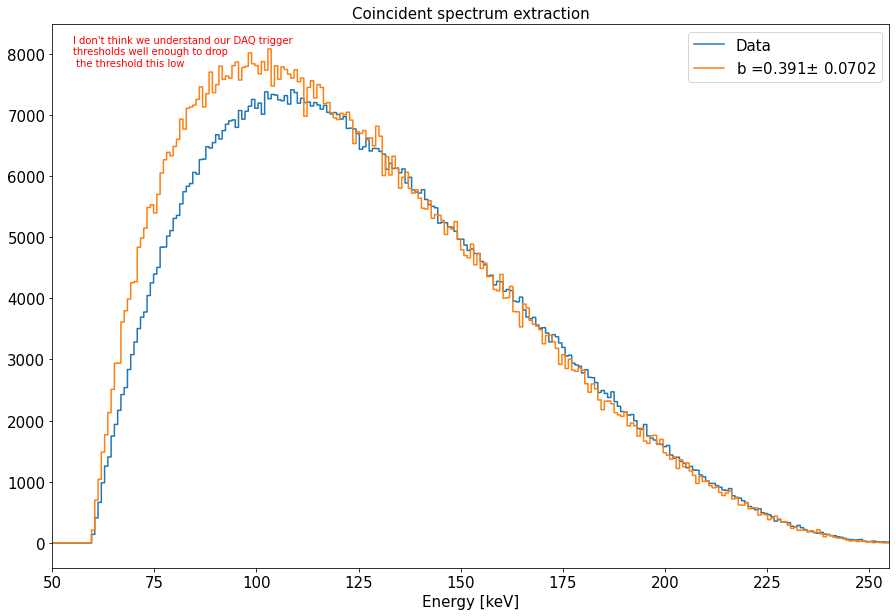

In [19]:
fs=15
trutharray=bins>-1
X=(trutharray,b0Hist,alpha*b1Hist)
fig,ax=subplots(figsize=(15,10))
ax.plot(bins,dataHist,ds='steps',label='Data')
ax.plot(bins,pd.fierz_fit(X,*pars),ds='steps',
        label=r'b ={b:0.3f}$\pm$ {berr:0.4f}'.format(b=pars[1],berr=vrs[1]))
# ax.plot(bins,b0Hist/max(b0Hist)*max(dataHist)*1.1,ds='steps',label='b=0',alpha=0.5)
# ax.plot(bins,b1Hist/max(b1Hist)*max(dataHist)*1.1,ds='steps',label='b=1',alpha=0.5)
# ax.plot(bins,pars[0]*b1Hist,ds='steps') 
ax.legend(fontsize=fs)
ax.tick_params(labelsize=fs)
ax.set_xlabel('Energy [keV]',fontsize=fs)
ax.set_title('Coincident spectrum extraction',fontsize=fs)
ax.set_xlim(50,255)
ax.text(55,7800,'I don\'t think we understand our DAQ trigger \nthresholds well enough to drop \n the threshold this low',color='red')
show()

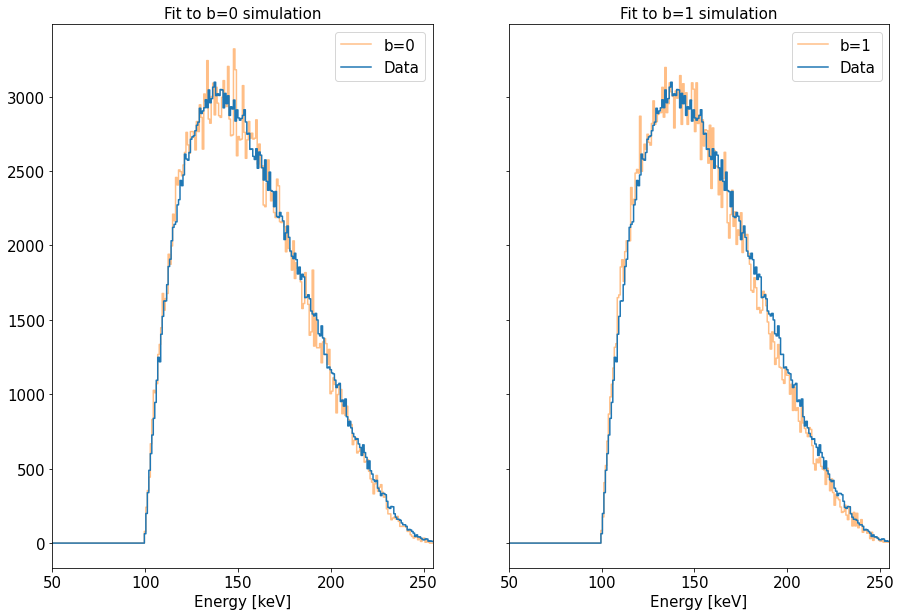

In [10]:
amp=lambda histogram,a: a*histogram 
t=dataHist>0
ampPar= [curve_fit(amp,b0Hist[t],dataHist[t],sigma=1/dataHist[t])[0]]
ampPar.append(curve_fit(amp,b1Hist[t],dataHist[t],sigma=1/dataHist[t])[0])
fs=15
fig,ax=subplots(ncols=2,sharey=True,figsize=(15,10))
ax[0].plot(bins,amp(b0Hist,ampPar[0]),ds='steps',label='b=0',alpha=0.5,color='C1')
ax[1].plot(bins,amp(b1Hist,ampPar[1]),ds='steps',label='b=1',alpha=0.5,color='C1')
# ax.plot(bins,b1Hist/max(b1Hist)*max(dataHist)*1.1,ds='steps',label='b=1',alpha=0.5)
# ax.plot(bins,pars[0]*b1Hist,ds='steps')
for i in(0,1):
    ax[i].plot(bins,dataHist,ds='steps',label='Data',color='C0')
    ax[i].legend(fontsize=fs)
    ax[i].tick_params(labelsize=fs)
    ax[i].set_xlabel('Energy [keV]',fontsize=fs)
    ax[i].set_title('Fit to b={:d} simulation'.format(i),fontsize=fs)
    ax[i].set_xlim(50,255)
show()

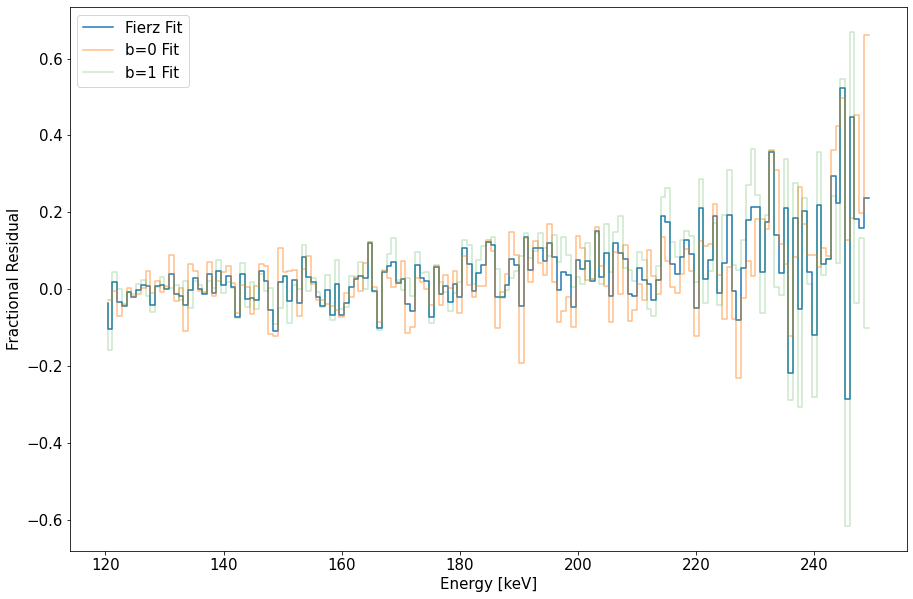

In [11]:
fig,ax=subplots(figsize=(15,10))
t=(bins>beg)*(bins<250)
ax.plot(bins[t],(dataHist-pd.fierz_fit(X,*pars))[t]/dataHist[t],ds='steps',label='Fierz Fit')
ax.plot(bins[t],(dataHist-amp(b0Hist,ampPar[0]))[t]/dataHist[t],ds='steps',label='b=0 Fit',alpha=0.5)
ax.plot(bins[t],(dataHist-amp(b1Hist,ampPar[1]))[t]/dataHist[t],ds='steps',label='b=1 Fit',alpha=0.25)

ax.set_xlabel('Energy [keV]',fontsize=fs)
ax.set_ylabel('Fractional Residual', fontsize=fs)
ax.tick_params(labelsize=fs)
ax.legend(loc=0,fontsize=fs)
show()